In [1]:
import os
import sys
import pickle
import warnings
import time
import logging
import glob


import numpy as np
from sklearn.neighbors import KDTree
import matplotlib.pyplot as plt
from iminuit import Minuit


from utils import *


import seaborn as sns
from matplotlib import rcParams
from cycler import cycler


## Set plotting style and print options
sns.set_theme()
sns.set_style("darkgrid")
sns.set_context("paper") #Possible are paper, notebook, talk and poster

d = {'lines.linewidth': 2, 'axes.titlesize': 20, 'axes.titleweight': 'bold', 'axes.labelsize': 18, 'xtick.labelsize': 12, 'axes.labelweight': 'bold', 'ytick.labelsize': 12,\
     'legend.fontsize': 15, 'font.family': 'serif', 'font.weight': 'bold', 'figure.titlesize': 20,'figure.titleweight': 'bold',\
          'figure.labelsize': 18,'figure.labelweight': 'bold', 'figure.figsize': (9,6), }
d_colors = {'axes.prop_cycle': cycler(color = ['teal', 'navy', 'coral', 'plum', 'purple', 'olivedrab',\
         'black', 'red', 'cyan', 'brown', 'green', 'yellow', 'khaki','lightblue'])}
rcParams.update(d)
rcParams.update(d_colors)
np.set_printoptions(precision = 5, suppress=1e-10)

In [2]:
output_path = 'C:\\Users\\Simon Andersen\\Documents\\Uni\\Speciale\\Hyperuniformity\\output'
save_path = 'data'
path0 = os.path.join(output_path, 'exp0')
sys.path.append(output_path)

Nexp = len(os.listdir(output_path))
Nframes = len(np.loadtxt(os.path.join(path0, 'Ndefects_act0.1.txt')))

act_list = []

for file in os.listdir(path0):
    if file.startswith('Ndefects'):
        activity = file.split('act')[-1].split('.txt')[0]
        act_list.append(float(activity))

Nactivity = len(act_list)

Nexp, Nframes,

(10, 181)

In [157]:
conv_list = [100, 160, 80, 35, 35, 20, 20, 0, 0, 0, 0, 0, 0, 0]
conv_dict = dict(zip(act_list, conv_list))

window_sizes = np.loadtxt(os.path.join(path0, 'window_sizes.txt'))

defect_arr = np.zeros((Nframes, Nactivity, Nexp))

for i, act in enumerate(act_list):
    for j, exp in enumerate(os.listdir(output_path)):
        path = os.path.join(output_path, exp)
        defect_arr[:, i, j] = np.loadtxt(os.path.join(path, 'Ndefects_act{}.txt'.format(act)))
np.save(os.path.join(save_path, 'defect_arr.npy'), defect_arr)


av_defects = np.zeros((Nactivity, 2))
defect_arr_av = np.mean(defect_arr, axis=2)
defect_arr_std = np.std(defect_arr, axis=2)

for i, act in enumerate(act_list):
    av_defects[i, 0] = np.mean(defect_arr_av[conv_dict[act]:, i])
    av_defects[i, 1] = np.mean(defect_arr_std[conv_dict[act]:, i]) / np.sqrt(Nframes - conv_dict[act])

np.save(os.path.join(save_path, 'av_defects.npy'), av_defects)


av_counts = np.nan * np.zeros([Nframes, len(window_sizes), Nactivity, Nexp])
var_counts = np.nan * np.zeros([Nframes, len(window_sizes), Nactivity, Nexp])

count_lengths = np.zeros([Nactivity, Nexp])
for i, act in enumerate(act_list):
    for j, exp in enumerate(os.listdir(output_path)):
        path = os.path.join(output_path, exp)
        counts = np.loadtxt(os.path.join(path, 'av_counts_act{}.txt'.format(act)))
        vars = np.loadtxt(os.path.join(path, 'count_fluctuations_act{}.txt'.format(act)))

        idx_start_count = min(Nframes - conv_list[i], len(counts))
        av_counts[-idx_start_count:, :, i, j] = counts[-idx_start_count:, :]
        var_counts[-idx_start_count:, :, i, j] = vars[-idx_start_count:, :]
        count_lengths[i, j] = idx_start_count
        
    print("First frame for activity {} is {}".format(act, Nframes - count_lengths[i, :]))

# save the average counts
np.save(os.path.join(save_path, 'av_counts.npy'), av_counts)
np.save(os.path.join(save_path, 'var_counts.npy'), var_counts)

av_counts_av = np.nanmean(av_counts, axis=3)
av_counts_std = np.nanstd(av_counts, axis=3, ddof=1) / np.sqrt(Nexp)

# save the average counts
np.save(os.path.join(save_path, 'av_counts_av.npy'), av_counts_av)
np.save(os.path.join(save_path, 'av_counts_std.npy'), av_counts_std)

var_counts_av = np.nanmean(var_counts, axis=3)
var_counts_std = np.nanstd(var_counts, axis=3, ddof=1) / np.sqrt(Nexp)

# save the average var counts
np.save(os.path.join(save_path, 'var_counts_av.npy'), var_counts_av)
np.save(os.path.join(save_path, 'var_counts_std.npy'), var_counts_std)

# find the density fluctuations by dividing by the window area
dens_fluc = var_counts / (np.pi * window_sizes[:, None, None] ** 2) ** 2
dens_fluc_av = np.nanmean(dens_fluc, axis=3)
dens_fluc_std = np.nanstd(dens_fluc, axis=3, ddof=1) / np.sqrt(Nexp)

# save the average density fluctuations
np.save(os.path.join(save_path, 'dens_fluc.npy'), dens_fluc)
np.save(os.path.join(save_path, 'dens_fluc_av.npy'), dens_fluc_av)
np.save(os.path.join(save_path, 'dens_fluc_std.npy'), dens_fluc_std)


First frame for activity 0.024 is [100. 100. 125. 100. 100. 100. 100. 100. 100. 100.]
First frame for activity 0.025 is [160. 160. 160. 160. 160. 160. 160. 160. 160. 160.]
First frame for activity 0.026 is [80. 80. 80. 80. 80. 80. 80. 80. 80. 80.]
First frame for activity 0.028 is [35. 35. 35. 35. 35. 35. 35. 35. 35. 35.]
First frame for activity 0.03 is [35. 35. 35. 35. 35. 35. 35. 35. 35. 35.]
First frame for activity 0.032 is [20. 20. 25. 20. 20. 20. 20. 20. 25. 20.]
First frame for activity 0.034 is [20. 20. 20. 20. 25. 20. 20. 20. 20. 20.]
First frame for activity 0.04 is [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
First frame for activity 0.05 is [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
First frame for activity 0.06 is [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
First frame for activity 0.07 is [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
First frame for activity 0.08 is [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
First frame for activity 0.09 is [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
First frame for activity 0.1 is [0. 0. 0. 0. 0. 0. 0. 0. 0.

C:\Users\Simon Andersen\AppData\Local\Temp\ipykernel_14432\505867024.py:47: RuntimeWarning: Mean of empty slice
  av_counts_av = np.nanmean(av_counts, axis=3)
c:\Users\Simon Andersen\miniconda3\envs\sf\lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\Simon Andersen\AppData\Local\Temp\ipykernel_14432\505867024.py:54: RuntimeWarning: Mean of empty slice
  var_counts_av = np.nanmean(var_counts, axis=3)
C:\Users\Simon Andersen\AppData\Local\Temp\ipykernel_14432\505867024.py:63: RuntimeWarning: Mean of empty slice
  dens_fluc_av = np.nanmean(dens_fluc, axis=3)


In [53]:
av_counts_av.shape

(181, 30, 14)

In [3]:
# load arrays

conv_list = [100, 160, 80, 35, 35, 20, 20, 0, 0, 0, 0, 0, 0, 0]
conv_dict = dict(zip(act_list, conv_list))

window_sizes = np.loadtxt(os.path.join(path0, 'window_sizes.txt'))

av_defects = np.load(os.path.join(save_path, 'av_defects.npy'))

defect_arr = np.load(os.path.join(save_path, 'defect_arr.npy'))
defect_arr_av = np.mean(defect_arr, axis=2)
defect_arr_std = np.std(defect_arr, axis=2)

av_counts = np.load(os.path.join(save_path, 'av_counts.npy'))
av_counts_av = np.nanmean(av_counts, axis=3)
av_counts_std = np.nanstd(av_counts, axis=3, ddof=1) / np.sqrt(Nexp)

var_counts = np.load(os.path.join(save_path, 'var_counts.npy'))
var_counts_av = np.nanmean(var_counts, axis=3)
var_counts_std = np.nanstd(var_counts, axis=3, ddof=1) / np.sqrt(Nexp)

dens_fluc = np.load(os.path.join(save_path, 'dens_fluc.npy'))
dens_fluc_av = np.nanmean(dens_fluc, axis=3)
dens_fluc_std = np.nanstd(dens_fluc, axis=3, ddof=1) / np.sqrt(Nexp)


C:\Users\Simon Andersen\AppData\Local\Temp\ipykernel_5428\3410013519.py:15: RuntimeWarning: Mean of empty slice
  av_counts_av = np.nanmean(av_counts, axis=3)
c:\Users\Simon Andersen\miniconda3\envs\tf\lib\site-packages\numpy\lib\nanfunctions.py:1872: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\Simon Andersen\AppData\Local\Temp\ipykernel_5428\3410013519.py:19: RuntimeWarning: Mean of empty slice
  var_counts_av = np.nanmean(var_counts, axis=3)
C:\Users\Simon Andersen\AppData\Local\Temp\ipykernel_5428\3410013519.py:23: RuntimeWarning: Mean of empty slice
  dens_fluc_av = np.nanmean(dens_fluc, axis=3)


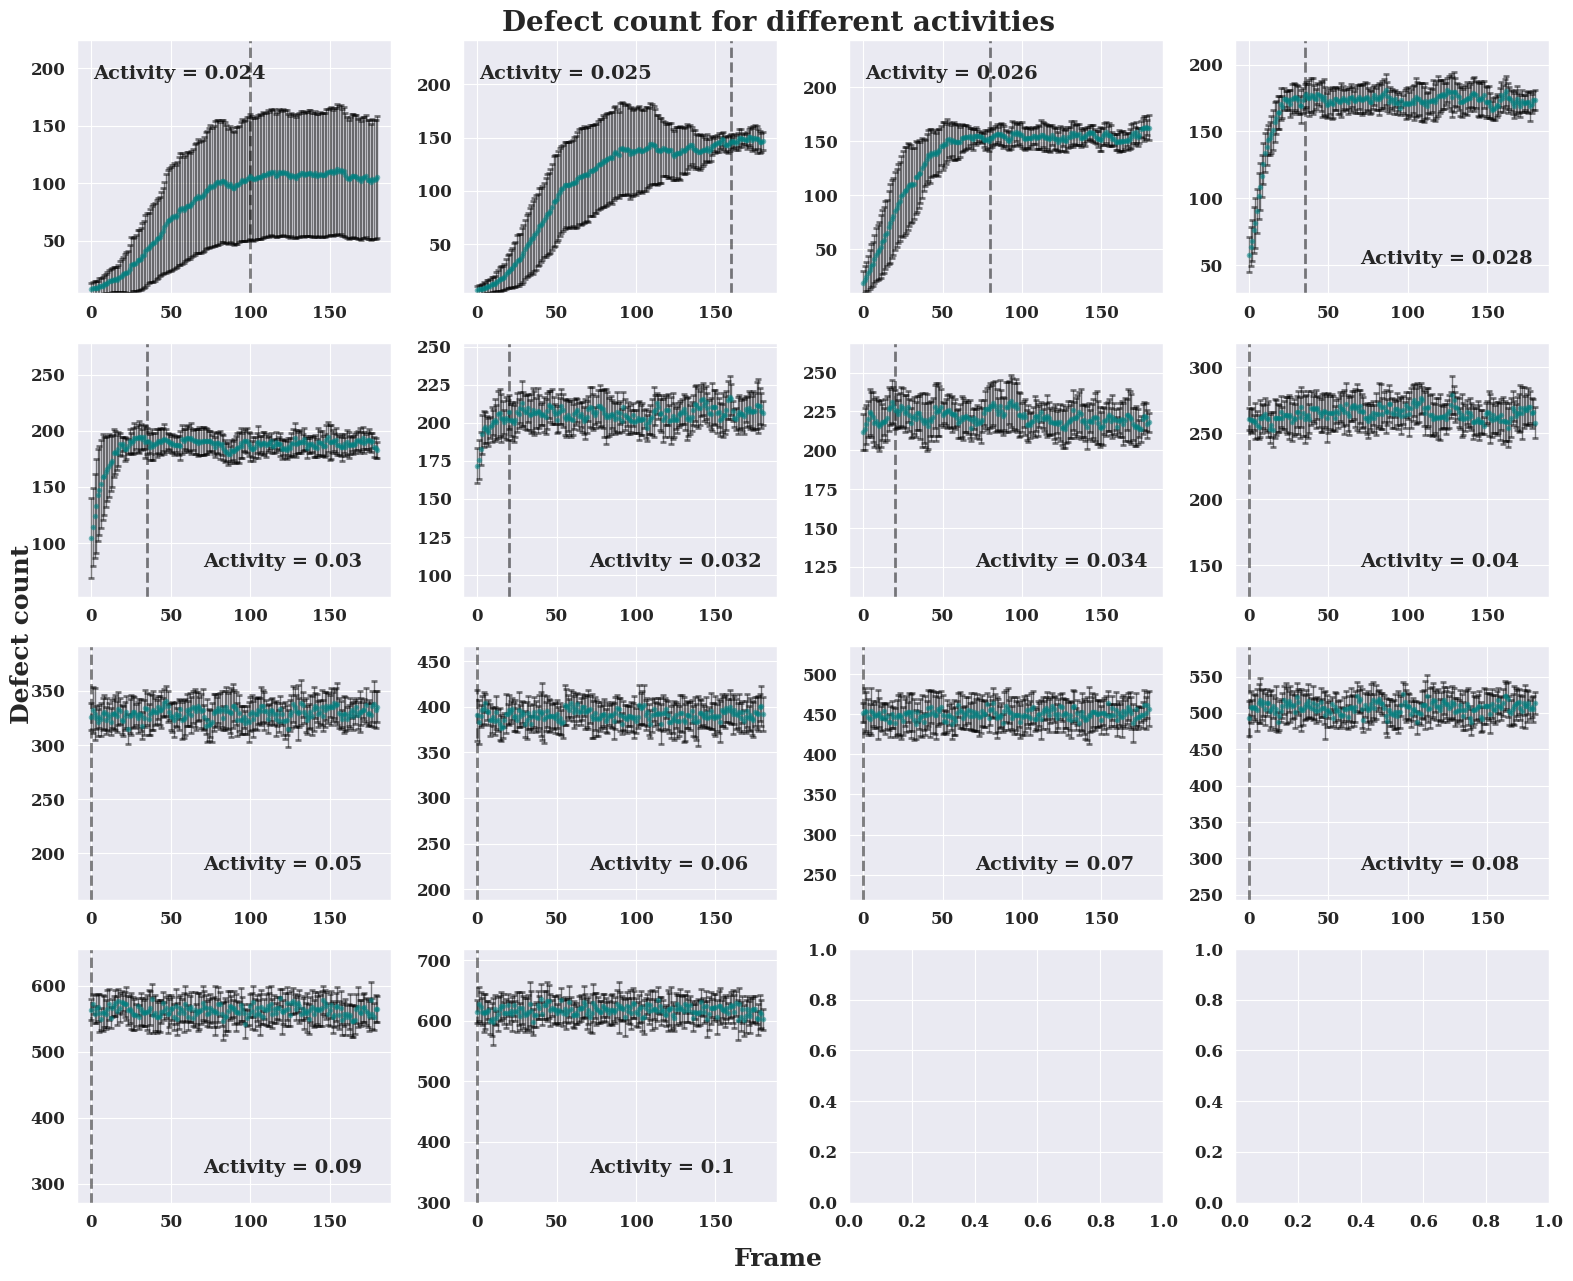

In [82]:

fig, ax = plt.subplots(nrows = 4, ncols = 4, figsize=(16, 13))
ax = ax.flatten()
for i, act in enumerate(act_list):
    ax[i].errorbar(np.arange(Nframes), defect_arr_av[:, i], defect_arr_std[:, i], label='activity = {}'.format(act), fmt='.', \
                   capsize=2, capthick=1, elinewidth=1, markeredgewidth=2, alpha = 0.5, markersize=4, ecolor='black')
    
    # plot vertical lines to indicate the start of the averaging
    ax[i].axvline(x=conv_dict[act], color='black', linestyle='--', alpha=0.5)
    ax[i].set_ylim(np.min(defect_arr_av[:,i])/2, np.max(defect_arr_av[:, i]) + 2  * np.max(defect_arr_std[:, i]))

    if i < 3:
        ax[i].text(0.05, 0.9, 'Activity = {}'.format(act), transform=ax[i].transAxes, fontsize=14, verticalalignment='top')
    else:
        ax[i].text(0.4, 0.1, 'Activity = {}'.format(act), transform=ax[i].transAxes, fontsize=14, verticalalignment='bottom')

fig.suptitle('Defect count for different activities')
fig.supxlabel('Frame')
fig.supylabel('Defect count')

plt.tight_layout()
plt.show()

In [4]:
def linear(x, a, b):
    return a * x + b
# Try fitting with other functions
def qudratic(x, a, b, c):
    return a * x**2 + b * x + c
def power(x, a, b, c, d):
    return a * x**d + b * x + c
def log_func(x, a, b, c):
    return a * np.log(x) + b*x + c

In [ ]:
# do a linear fit to the average defect density

param_guess_lin = np.array([70 * 100, 100])
param_guess_quad = np.array([70 * 100, 100, 0])
param_guess_power = np.array([7000, 2, 7100, -29])
param_guess_log = np.array([7000, 300, 30])
fit_func = log_func
fit_string = rf'$y = a x^2 + bx + c$'
fit_string = rf'$y = a \ln x + bx + c $'

param_guess = param_guess_log
# fit starting with different lower activity values
for i in range(1, len(act_list) - 1):
    lin_fit = do_chi2_fit(fit_func, act_list[i:], av_defects[i:, 0], av_defects[i:, 1], parameter_guesses= param_guess, verbose=False)

    print("Fitting only activities >= {}".format(act_list[i]))
    Ndof, chi2, pval = get_statistics_from_fit(lin_fit, len(act_list[i:]))
    print("Ndof, chi2, pval: ", Ndof, np.round(chi2, 2), np.round(pval, 7))
print("\n\n")

for i in range(3, len(act_list) - 1):
    lin_fit = do_chi2_fit(fit_func, act_list[1:i], av_defects[1:i, 0], av_defects[1:i, 1], parameter_guesses= param_guess, verbose=False)

    print("Fitting only activities < {}".format(act_list[i]))
    Ndof, chi2, pval = get_statistics_from_fit(lin_fit, len(act_list[1:i]))
    print("Ndof, chi2, pval: ", Ndof, np.round(chi2, 2), np.round(pval, 5))
 
lower_act_index = act_list.index(0.025)
upper_act_index = act_list.index(0.07)

lin_fit = do_chi2_fit(fit_func, act_list[lower_act_index:], av_defects[lower_act_index:, 0], av_defects[lower_act_index:, 1], parameter_guesses= param_guess, verbose=False)
Ndof, chi2, pval = get_statistics_from_fit(lin_fit, len(act_list[lower_act_index:]))

lin_fit_lower = do_chi2_fit(fit_func, act_list[1:upper_act_index], av_defects[1:upper_act_index, 0], av_defects[1:upper_act_index, 1], parameter_guesses= param_guess, verbose=False)
Ndof_lower, chi2_lower, pval_lower = get_statistics_from_fit(lin_fit_lower, len(act_list[1:upper_act_index]))

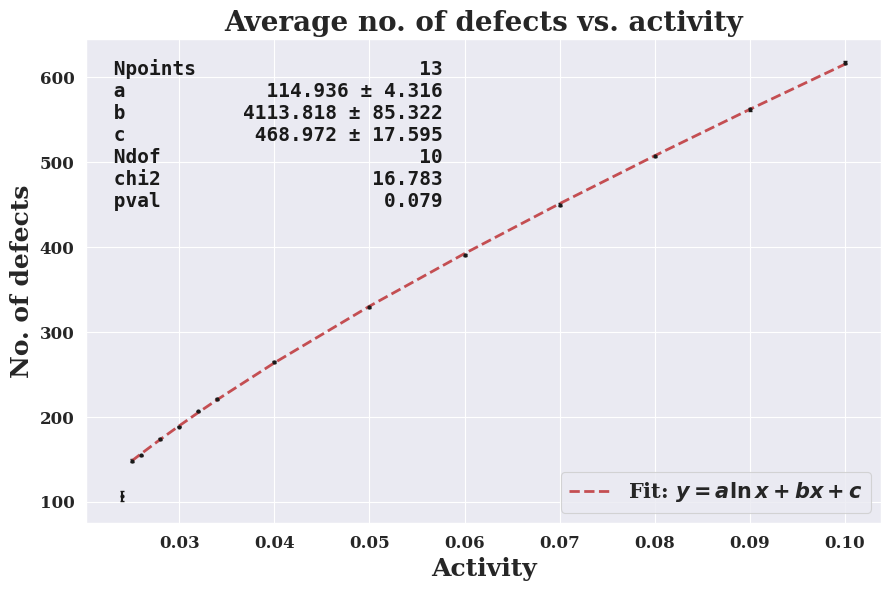

In [6]:
fig, ax = plt.subplots(figsize=(9, 6))
ax.errorbar(act_list, av_defects[:, 0], yerr = av_defects[:, 1], fmt = 'k.', elinewidth=1.5, capsize=1.5, capthick=1, markersize = 4)
ax.set_xlabel('Activity')
ax.set_ylabel('No. of defects')
ax.set_title('Average no. of defects vs. activity')

ax.plot(act_list[lower_act_index:], fit_func(np.array(act_list[lower_act_index:]), *lin_fit.values[:]), 'r--', label=rf'Fit: {fit_string}')
#ax.plot(act_list[1:upper_act_index], fit_func(np.array(act_list[1:upper_act_index]), *lin_fit_lower.values[:]), 'b--', label='Fit 2')

#d = generate_dictionary(lin_fit, len(act_list[lower_act_index:]), chi2_suffix='1')
#d_lower = generate_dictionary(lin_fit_lower, len(act_list[1:upper_act_index]))

#d = {'a': [lin_fit.values['a'], lin_fit.errors['a']], 'b': [lin_fit.values['b'], lin_fit.errors['b']]}

d = {'Fit1: y = a1x + b1': '', 'a1': [lin_fit.values['a'], lin_fit.errors['a']], 'b1': [lin_fit.values['b'],lin_fit.errors['b'] ],\
      'Fit1 Ndof1': Ndof, 'chi2val1': chi2, 'pval1': pval}
d_lower = {'Fit2: y = a2x + b2': '', 'a2': [lin_fit_lower.values['a'], lin_fit_lower.errors['a']], 'b2': [lin_fit_lower.values['b'],lin_fit_lower.errors['b'] ],\
      'Fit2 Ndof2': Ndof_lower, 'chi2val2': chi2_lower, 'pval2': pval_lower}

d = generate_dictionary(lin_fit, len(act_list[lower_act_index:]), chi2_suffix = None)

#d.update(d_lower)
text = nice_string_output(d, extra_spacing=4, decimals=3)
add_text_to_ax(0.02, 0.96, text, ax, fontsize=14)
ax.legend(loc='lower right')

fig.tight_layout()
plt.show()

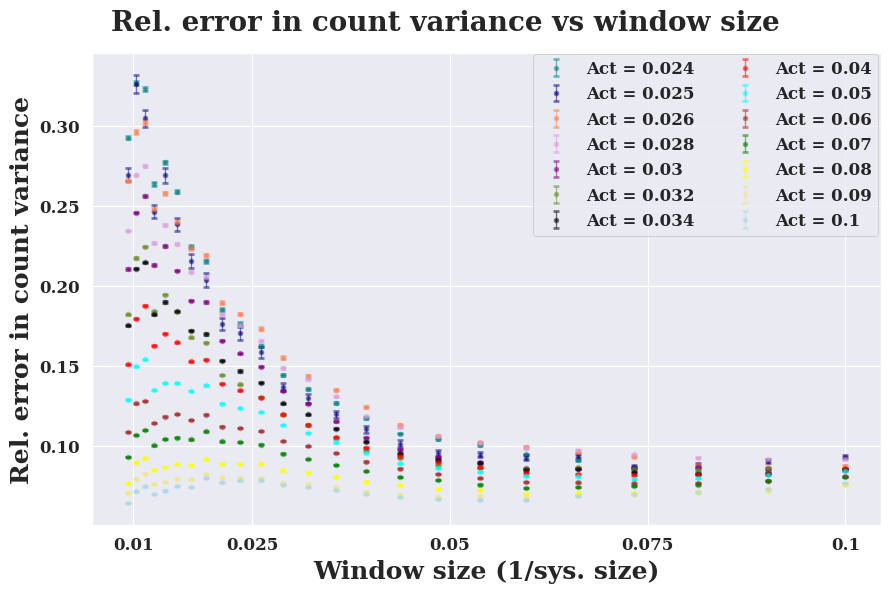

In [71]:
min_window_idx = 6

rel_error = var_counts_std[:,min_window_idx:,:] / var_counts_av[:,min_window_idx:,:]
rel_error_av = np.nanmean(rel_error, axis=0)

Nframes_non_nan_counts = np.sum(~np.isnan(av_counts_av[:,min_window_idx:,:]), axis=0)[0]

rel_error_std = np.nanstd(rel_error, axis=0, ddof=1) / Nframes_non_nan_counts[np.newaxis, :]

fig, ax = plt.subplots(figsize=(9,6))
for i, act in enumerate(act_list):
    ax.errorbar(window_sizes[min_window_idx:], rel_error_av[:,i], rel_error_std[:,i], fmt='.', label = f'Act = {act}',\
                        capsize=2, capthick=1, elinewidth=1, markeredgewidth=2, alpha = 0.5, markersize=4)
    
ax.set_xlabel('Window size (1/sys. size)')
ax.set_ylabel('Rel. error in count variance')
fig.suptitle('Rel. error in count variance vs window size')
#ax.legend(loc='upper right')

xticks = np.array([1, 2.5, 5, 7.5, 10]) * 2.56
ax.set_xticks(xticks, labels = np.round(xticks / 256,3))
fig.legend(ncol=2, fontsize = 12, bbox_to_anchor=(0.99, 0.92))
fig.tight_layout()


In [94]:
def lin_func(x, alpha, beta):
    return beta * (2 - alpha) + (2 - alpha) * x
def power_func(x, b): #, c, d, e):
    return  b * x ** 2
def power_log_func(x, b): #, c, d, e):
    return  b * x ** 2 * np.log(x)

param_guess_lin = np.array([0.1, 0.3])
param_guess_power = np.array([2400])
param_guess_power_log = np.array([2000])

frame = 165
R = window_sizes[min_window_idx:]





In [109]:
fit_func = lin_func
param_guess = param_guess_lin
log_fit = True
fit_string = rf'$y = \beta(2-\alpha) + (2-\alpha)x$'
save_suffix = 'lin'
normalize = True


# Initial arrays to store the fit parameters and errors for all activities and frames
Nparams = len(param_guess)
fit_params = np.zeros([Nframes, len(act_list), 2 * Nparams]) * np.nan
stat_arr = np.zeros([Nframes, len(act_list), 3]) * np.nan

Nframes_non_nan_counts = np.sum(~np.isnan(av_counts_av[:,min_window_idx:,:]), axis=0)[0]
first_frame_list = Nframes - Nframes_non_nan_counts



In [111]:
for i, act in enumerate(act_list):  
    for frame in np.arange(first_frame_list[i], Nframes):
        count_var_av = var_counts_av[frame, min_window_idx:, i]
        count_var_std = var_counts_std[frame, min_window_idx:, i]

        if normalize:
            av_count_all_windows = np.nanmean(av_counts_av[frame, min_window_idx:, i])
            count_var_av = count_var_av / av_count_all_windows ** 2
            count_var_std = count_var_std / av_count_all_windows ** 2

        if log_fit:
            x = np.log(R)
            y = np.log(count_var_av)
            yerr = count_var_std / count_var_av
        else:
            x = R
            y = count_var_av
            yerr = count_var_std

        with warnings.catch_warnings():
            warnings.simplefilter("ignore", category=np.VisibleDeprecationWarning)
            fit = do_chi2_fit(fit_func, x, y, yerr, param_guess, verbose = False)

        Ndof, chi2, prop = get_statistics_from_fit(fit, len(R), subtract_1dof_for_binning = False)
 
        fit_params[frame, i, :Nparams] = fit.values[:]
        fit_params[frame, i, Nparams:] = fit.errors[:]
        stat_arr[frame, i, :] = Ndof, chi2, prop
     
# save

np.save(os.path.join(save_path, f'fit_params_{save_suffix}_normalize{normalize}.npy'), fit_params)
np.save(os.path.join(save_path, f'stat_arr_{save_suffix}_normalize{normalize}.npy'), stat_arr)

In [76]:
def calc_weighted_mean(x, dx):
    """
    returns: weighted mean, error on mean, Ndof, Chi2, p_val
    """
    assert(len(x) > 1)
    assert(len(x) == len(dx))
    
    var = 1 / np.sum(1 / dx ** 2)
    mean = np.sum(x / dx ** 2) * var

    # Calculate statistics
    Ndof = len(x) - 1
    chi2 = np.sum((x - mean) ** 2 / dx ** 2)
    p_val = stats.chi2.sf(chi2, Ndof)

    return mean, np.sqrt(var), Ndof, chi2, p_val


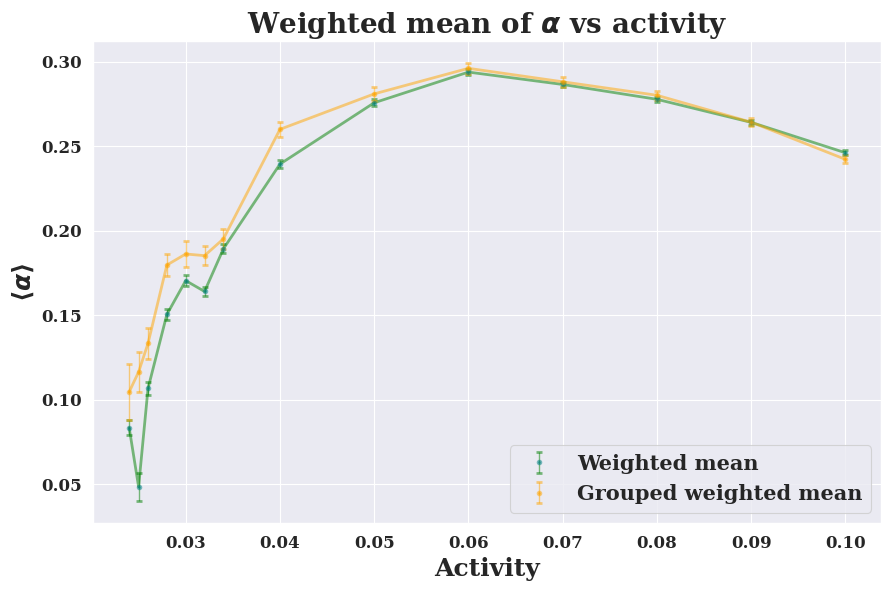

In [141]:
# calc weighted mean and error on mean for all frames and activities

Ngroup = 5
group = True
weighted_means_list = []
weighted_errs_list = []
weighted_means_group_list = []
weighted_errs_group_list = []

min_act_idx = act_list.index(0.024)

for i, act in enumerate(act_list[min_act_idx:]):
        if group:
                x = fit_params[first_frame_list[i + min_act_idx]:, i + min_act_idx, 0]

                max_idx = len(x) - len(x) % Ngroup
                # group the data and calculate the weighted mean and error on mean
                x_group = x[:max_idx].reshape(-1, Ngroup).mean(axis=1)
                dx_group = np.std(x[:max_idx].reshape(-1, Ngroup), axis=1, ddof=min(Ngroup-2, 1)) / np.sqrt(Ngroup)

                mean, err, Ndof, chi2, p_val = calc_weighted_mean(x_group, dx_group)
                weighted_means_group_list.append(mean)
                weighted_errs_group_list.append(err)
      
        x = fit_params[first_frame_list[i + min_act_idx]:, i + min_act_idx, 0]
        dx = fit_params[first_frame_list[i + min_act_idx]:, i + min_act_idx, Nparams]


        mean, err, Ndof, chi2, p_val = calc_weighted_mean(x, dx)
        weighted_means_list.append(mean)
        weighted_errs_list.append(err)


fig2, ax2 = plt.subplots(figsize=(9,6))
ax2.errorbar(act_list[min_act_idx:], weighted_means_list, weighted_errs_list, fmt='.', label = 'Weighted mean', \
             capsize=2, capthick=1, elinewidth=1, markeredgewidth=2, alpha = 0.5, markersize=4, ecolor='green')
ax2.plot(act_list[min_act_idx:], weighted_means_list, color='green', alpha=0.5)
ax2.errorbar(act_list[min_act_idx:], weighted_means_group_list, weighted_errs_group_list, fmt='.', label = 'Grouped weighted mean', \
             capsize=2, capthick=1, elinewidth=1, markeredgewidth=2, alpha = 0.5, markersize=4, ecolor='orange', color = 'orange')
ax2.plot(act_list[min_act_idx:], weighted_means_group_list, color='orange', alpha=0.5)


ax2.set_xlabel('Activity')
ax2.set_ylabel(rf'$\langle\alpha \rangle$')
ax2.set_title(rf'Weighted mean of $\alpha $ vs activity')
ax2.legend()
fig2.tight_layout()

In [128]:
activities_non_conv = []
frames_non_conv = []

for i, act in enumerate(act_list):
    p_mask = (0.05 > stat_arr[first_frame_list[i]:, i, 2])

    non_conv_frames = np.arange(first_frame_list[i], Nframes)[p_mask]

    pval = stat_arr[non_conv_frames, i, -1]

    if len(non_conv_frames) > 0:
        activities_non_conv.extend([act] * len(non_conv_frames))
        frames_non_conv.extend(non_conv_frames)


print(len(activities_non_conv))
    

29


In [ ]:

count = 0
act_target = 0.025

for j, frame in enumerate(frames_non_conv):
    if count > 10:
        break

    act = activities_non_conv[j]
    i = act_list.index(act)

    if act == activities_non_conv[j] and count < 10:
        fig, ax = plt.subplots(figsize=(9,6))
        count += 1

        pval = stat_arr[frame, i, -1]
        print("for activity {}".format(act), "the non-convergent frames are {}".format(frames_non_conv[j]), "with p-values {:.3e}".format(pval))

        ax.errorbar(window_sizes[min_window_idx:], var_counts_av[frame, min_window_idx:,i], var_counts_std[frame, min_window_idx:,i], fmt='.', label = f'Act = {act}',\
                            capsize=2, capthick=1, elinewidth=1, markeredgewidth=2, alpha = 0.5, markersize=4)
        
        fit_vals = fit_func(np.log(R), *fit_params[frame, i, :Nparams])
        ax.plot(R, np.exp(fit_vals), 'r--', label=rf'Fit: {fit_string}')
        ax.text(0.05, 0.97, f'pval = {pval:.3e}, act = {act}, frame = {frame}', transform=ax.transAxes, fontsize=12, verticalalignment='top')
 
        ax.set_xlabel('Window size (1/sys. size)')
        ax.set_ylabel('$\sigma_N^2$')
        fig.suptitle('Count variance vs window size')
        #ax.legend(loc='upper right')
        ax.set_yscale('log')
        ax.set_xscale('log')
        

        xticks = np.array([1, 2.5, 5, 7.5, 10]) * 2.56
        ax.set_xticks(xticks, labels = np.round(xticks / 256,3))
        fig.legend(ncol=2, fontsize = 10, bbox_to_anchor=(0.55, 0.715))
        fig.tight_layout()
    

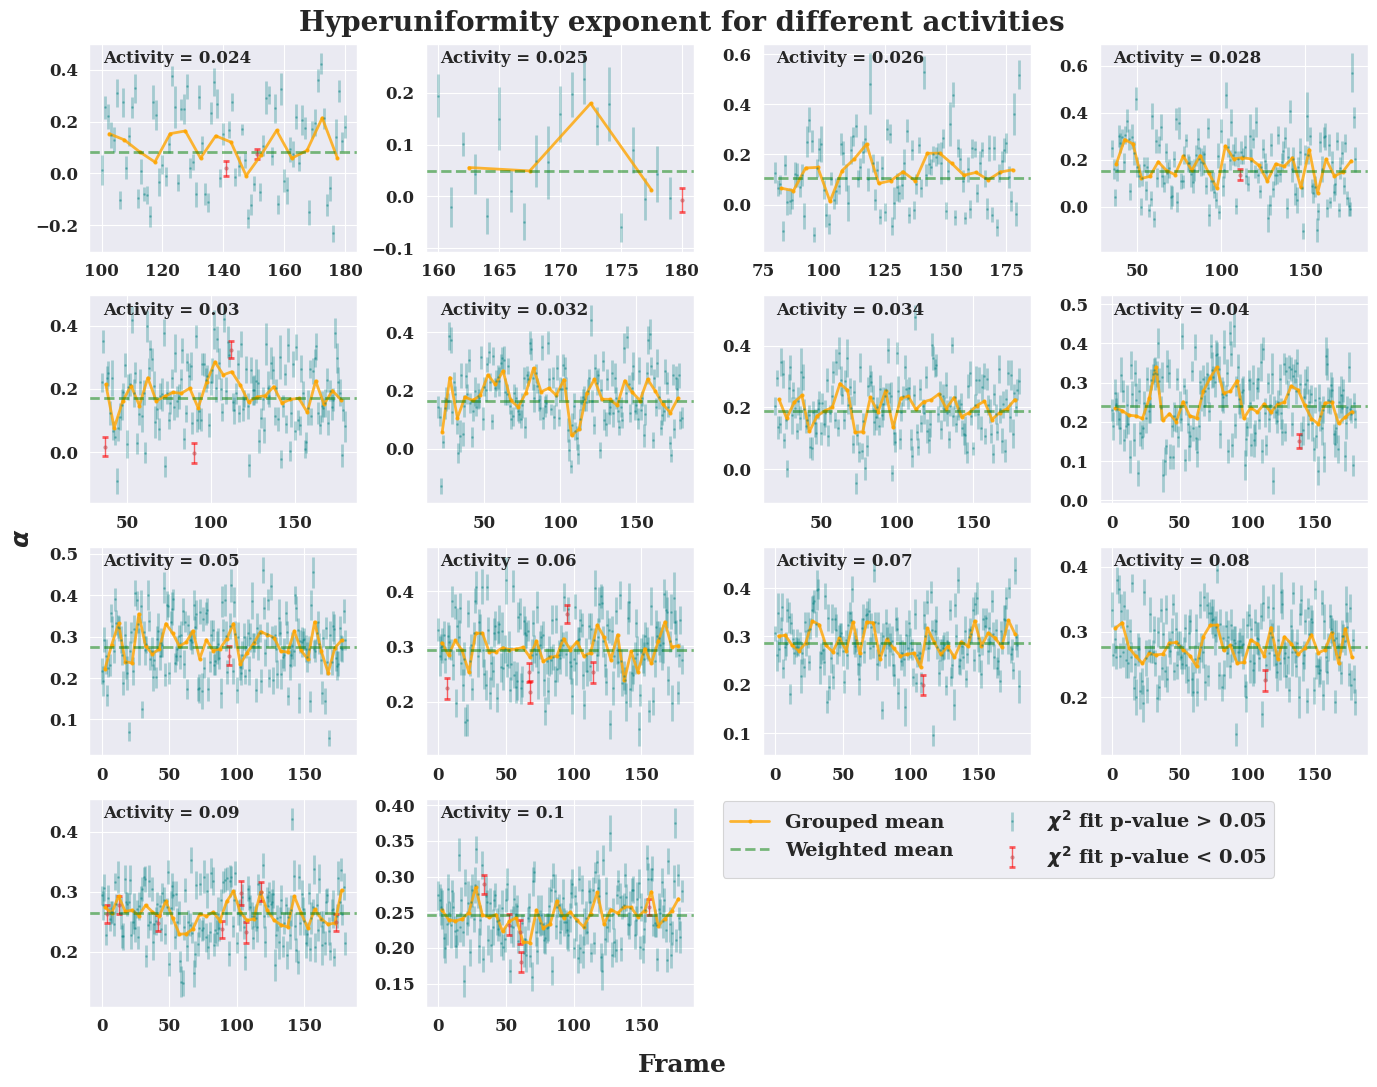

In [168]:
fig, ax = plt.subplots(nrows = 4, ncols = 4, figsize=(14, 11))

ax = ax.flatten()
Ngroup = 5

for i, act in enumerate(act_list):
    if i == 0:
        label1 = rf'$\chi^2$ fit p-value > 0.05'
        label2 = rf'$\chi^2$ fit p-value < 0.05'
        label3 = 'Weighted mean'
        label4 = 'Grouped mean'
    else:
        label1 = None
        label2 = None
        label3 = None
        label4 = None

    p_mask = stat_arr[first_frame_list[i]:, i, 2] > 0.05

    ax[i].errorbar(np.arange(first_frame_list[i], Nframes)[p_mask], \
                   fit_params[first_frame_list[i]:,i,0][p_mask], \
                    fit_params[first_frame_list[i]:,i,Nparams][p_mask], \
                       fmt='.', \
                   alpha = 0.3, markersize=2, label = label1)# ecolor='black')capsize=2, capthick=1, elinewidth=1, markeredgewidth=2, 
    
    ax[i].errorbar(np.arange(first_frame_list[i], Nframes)[~p_mask], \
                     fit_params[first_frame_list[i]:,i,0][~p_mask], \
                      fit_params[first_frame_list[i]:,i,Nparams][~p_mask], \
                        fmt='r.', \
                     capsize=2, capthick=1, elinewidth=1, markeredgewidth=2, alpha = 0.6, markersize=2, ecolor='red', label = label2)

    x = fit_params[first_frame_list[i]:, i, 0]

    max_idx = len(x) - len(x) % Ngroup 
    # group the data and calculate the weighted mean and error on mean
    x_group = x[:max_idx].reshape(-1, Ngroup).mean(axis=1)
    dx_group = np.std(x[:max_idx].reshape(-1, Ngroup), axis=1, ddof=min(Ngroup-2, 1)) / np.sqrt(Ngroup)
    x_frames = np.arange(first_frame_list[i], first_frame_list[i] + max_idx, Ngroup) + Ngroup / 2

    # plot x_group and dx_group
    ax[i].plot(x_frames, x_group, '.-', color='orange', alpha=0.8, markersize=4, label = label4)
    if 0:
        ax[i].errorbar(x_frames, \
                    x_group, \
                        dx_group, \
                        fmt='.', \
                    alpha = 0.5, markersize=4, ecolor='orange')


    mean, err, Ndof, chi2, p_val = calc_weighted_mean(x_group, dx_group)
    #ax[i].axhline(mean, color='orange', linestyle='-', alpha=0.5, lw = 2, label = label3)
    

    # calc and plot weighted mean and error on mean for all frames and activities
    mean, err, Ndof, chi2, p_val = calc_weighted_mean(x, fit_params[first_frame_list[i]:, i, Nparams])
    ax[i].axhline(mean, color='green', linestyle='--', alpha=0.5, lw = 2, label = label3)
    
    # plot vertical lines to indicate the start of the averaging
  #  ax[i].axhline(0, color='black', linestyle='--', alpha=0.5)
    #ax[i].set_ylim(np.min(defect_arr_av[:,i])/2, np.max(defect_arr_av[:, i]) + 2  * np.max(defect_arr_std[:, i]))
    ax[i].text(0.05, 0.97, 'Activity = {}'.format(act), transform=ax[i].transAxes, fontsize=12, verticalalignment='top')
    if 0:
        if i < 3:
            ax[i].text(0.05, 0.9, 'Activity = {}'.format(act), transform=ax[i].transAxes, fontsize=14, verticalalignment='top')
        else:
            ax[i].text(0.4, 0.1, 'Activity = {}'.format(act), transform=ax[i].transAxes, fontsize=14, verticalalignment='bottom')

ax[-2].axis('off')
ax[-1].axis('off')

fig.suptitle('Hyperuniformity exponent for different activities')
fig.supxlabel('Frame')
fig.supylabel(rf'$\alpha$')
fig.legend(ncol=2, fontsize = 14,bbox_to_anchor=(0.93, 0.27))

plt.tight_layout()
plt.show()

In [150]:

from statsmodels.tsa.stattools import adfuller
def do_adf_test(time_series, maxlag = None, autolag = 'AIC', regression = 'c', verbose = True):
    """
    Performs the augmented Dickey-Fuller test on a time series.
    """
    result = adfuller(time_series, maxlag = maxlag, autolag = autolag, regression = regression)
    if verbose:
        print(f'ADF Statistic: {result[0]}')
        print(f'p-value: {result[1]}')
        print(f'nobs used: {result[3]}')
        print(f'lags used: {result[2]}')
        print(f'Critical Values:')
        
        for key, value in result[4].items():
            print(f'\t{key}: {value}')

    return result

In [ ]:
for i, act in enumerate(act_list):
    print("For activity = {}".format(act))
  #  max_lag = int(Nframes_non_nan_counts[i]/ 2 - 2)
    max_lag = int(5 / 50 * Nframes_non_nan_counts[i])
    print(max_lag)
    do_adf_test(fit_params[first_frame_list[i]:, i, 0], maxlag = max_lag, autolag = None, regression = 'c', verbose = True)
    print("\n")

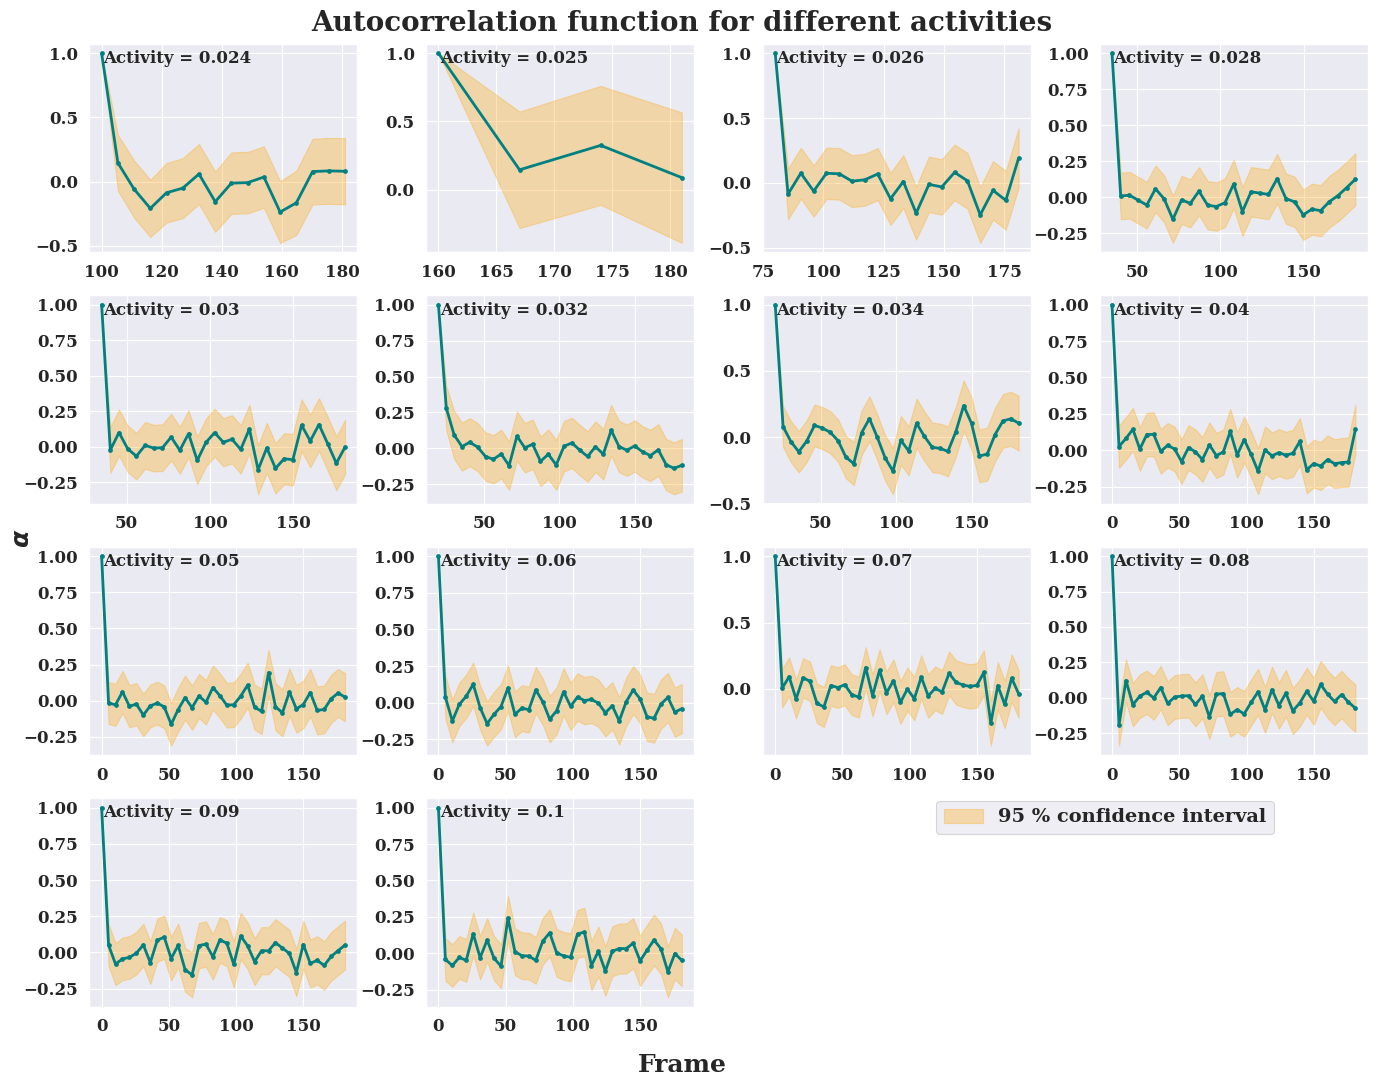

In [126]:
import statsmodels.api as sm


fig, ax = plt.subplots(nrows = 4, ncols = 4, figsize=(14, 11))

ax = ax.flatten()
Ngroup = 5

for i, act in enumerate(act_list):
    if i == 0:
        label1 = rf'$\chi^2$ fit p-value > 0.05'
        label2 = rf'$\chi^2$ fit p-value < 0.05'
        label3 = 'Weighted mean'
        label4 = '95 % confidence interval'
    else:
        label1 = None
        label2 = None
        label3 = None
        label4 = None

    nlags = int(Nframes_non_nan_counts[i]/Ngroup)

    autocorr, conf_int = sm.tsa.stattools.acf(fit_params[first_frame_list[i]:,i,0], nlags=nlags - 1, \
                                              fft=False, adjusted=True, bartlett_confint=True, alpha = 0.05)
    frames = np.linspace(first_frame_list[i], Nframes, nlags)

    # plot the confidence interval
    conf_int_err = np.zeros_like(conf_int)
    conf_int_err[:,0] = autocorr - conf_int[:,0]
    conf_int_err[:,1] = conf_int[:,1] - autocorr

    ax[i].fill_between(frames, conf_int[:,0], conf_int[:,1], alpha=0.3, color='orange', label = label4)


    ax[i].plot(frames, autocorr, '.-',)# ecolor='black')capsize=2, capthick=1, elinewidth=1, markeredgewidth=2,

    ax[i].text(0.05, 0.97, 'Activity = {}'.format(act), transform=ax[i].transAxes, fontsize=12, verticalalignment='top')


ax[-2].axis('off')
ax[-1].axis('off')


fig.suptitle('Autocorrelation function for different activities')
fig.supxlabel('Frame')
fig.supylabel(rf'$\alpha$')
fig.legend(ncol=2, fontsize = 14,bbox_to_anchor=(0.93, 0.27))

plt.tight_layout()
plt.show()



In [221]:
count_var_std

array([0.015  , 0.01767, 0.02445, 0.02787, 0.03823, 0.04097, 0.04423,
       0.05176, 0.05824, 0.06988, 0.07948, 0.09917, 0.12714, 0.13426,
       0.13723, 0.14012, 0.14739, 0.19853, 0.24048, 0.27883, 0.36976,
       0.40859, 0.61643, 0.81859])

In [57]:
av_counts_av.shape

(181, 30, 14)

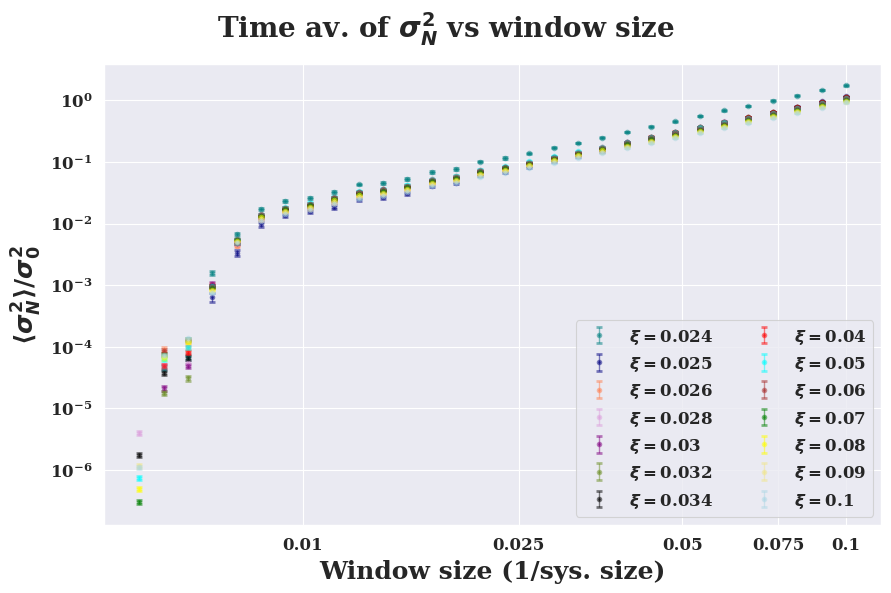

In [147]:
frame = 30
min_window_idx = 0

Nframes_non_nan_counts = np.sum(~np.isnan(av_counts_av[:,min_window_idx:,:]), axis=0)[0]


fig, ax = plt.subplots(figsize=(9,6))
for i, act in enumerate(act_list):
    

    frames_av_count = np.mean(av_counts_av[first_frame_list[i]:, min_window_idx:,i], axis = 1)

    avv = var_counts_av[first_frame_list[i]:, min_window_idx:,i] / frames_av_count[:, None] ** 2
    std = var_counts_std[first_frame_list[i]:, min_window_idx:,i] / frames_av_count[:, None] ** 2
  #  ax.errorbar(window_sizes[min_window_idx:], np.mean(var_counts_av[first_frame_list[i]:, min_window_idx:,i], axis=0), \
   #             np.mean(var_counts_std[first_frame_list[i]:, min_window_idx:,i], axis=0)/np.sqrt(Nframes_non_nan_counts[i]), fmt='.', label = f'Act = {act}',\
    #                    capsize=2, capthick=1, elinewidth=1, markeredgewidth=2, alpha = 0.5, markersize=4)
    ax.errorbar(window_sizes[min_window_idx:], np.mean(avv, axis=0), \
                np.mean(std, axis=0)/np.sqrt(Nframes_non_nan_counts[i]), fmt='.', label = fr'$\xi = ${act}',\
                        capsize=2, capthick=1, elinewidth=1, markeredgewidth=2, alpha = 0.5, markersize=4)
  #  print(np.mean(avv, axis=0))
ax.set_xlabel('Window size (1/sys. size)')
ax.set_ylabel(rf'$\langle \sigma_N^2 \rangle /  \sigma_0^2$')
fig.suptitle(rf'Time av. of $ \sigma_N^2$ vs window size')
#ax.legend(loc='upper right')
ax.set_yscale('log')
ax.set_xscale('log')

xticks = np.array([1, 2.5, 5, 7.5, 10]) * 2.56
ax.set_xticks(xticks, labels = np.round(xticks / 256,3))
ax.legend(ncol=2, fontsize = 12, loc = 'lower right') #bbox_to_anchor=(0.65, 0.45))
fig.tight_layout()

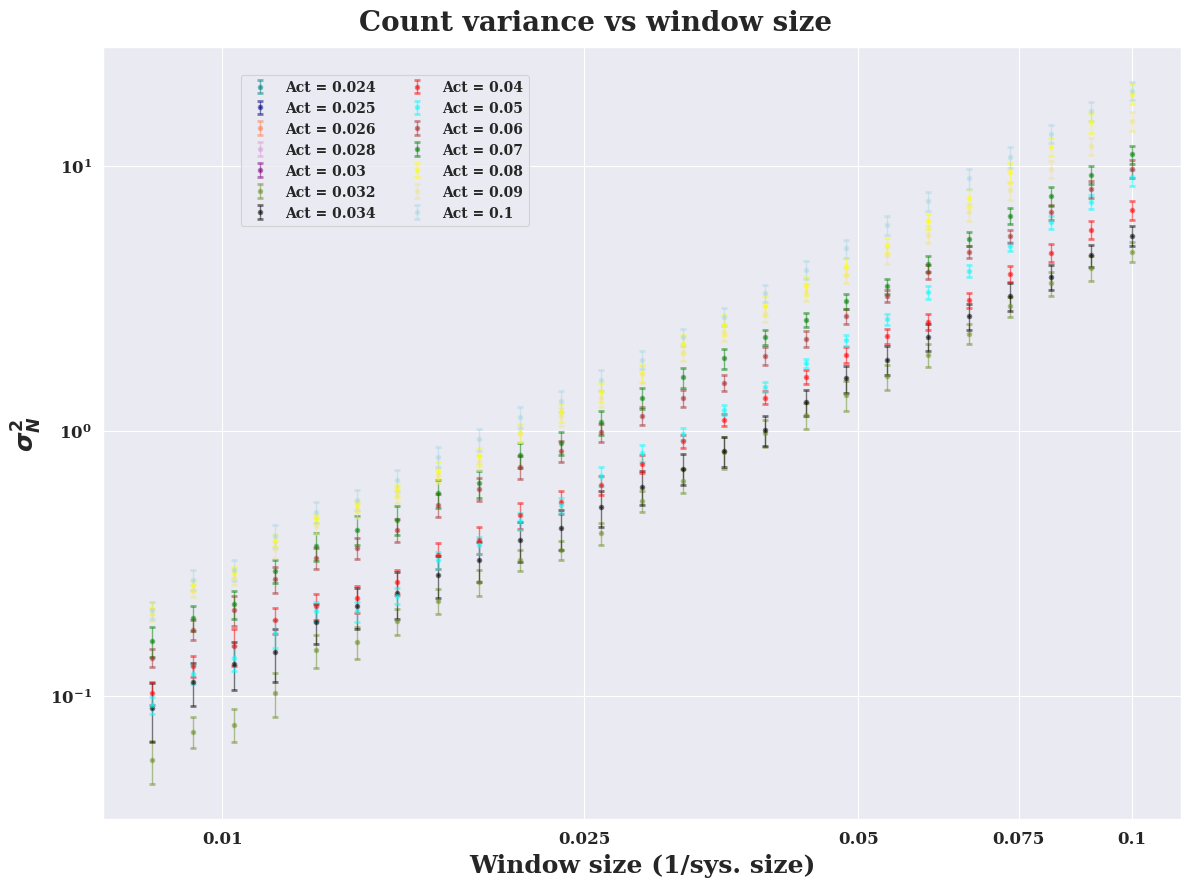

In [158]:

frame = 30

Nframes_non_nan_counts = np.sum(~np.isnan(av_counts_av[:,min_window_idx:,:]), axis=0)[0]


fig, ax = plt.subplots(figsize=(12,9))
for i, act in enumerate(act_list):
    ax.errorbar(window_sizes[min_window_idx:], var_counts_av[frame, min_window_idx:,i], var_counts_std[frame, min_window_idx:,i], fmt='.', label = f'Act = {act}',\
                        capsize=2, capthick=1, elinewidth=1, markeredgewidth=2, alpha = 0.5, markersize=4)
    
ax.set_xlabel('Window size (1/sys. size)')
ax.set_ylabel('$\sigma_N^2$')
fig.suptitle('Count variance vs window size')
#ax.legend(loc='upper right')
ax.set_yscale('log')
ax.set_xscale('log')

xticks = np.array([1, 2.5, 5, 7.5, 10]) * 2.56
ax.set_xticks(xticks, labels = np.round(xticks / 256,3))
fig.legend(ncol=2, fontsize = 10, bbox_to_anchor=(0.45, 0.915))
fig.tight_layout()

In [ ]:
frames = [160, 170, 180]
markers = ['.', 'x', 'o', 'v', 's', 'p', 'P', '*', 'X', 'D', 'd', '1', '2', '3']
logplot = True
min_window_idx = 5

fig, ax = plt.subplots(nrows = 2, ncols = 2, figsize=(14, 11))
ax = ax.flatten()
for i, f in enumerate(frames):
    for j, act in enumerate(act_list[7:]):
        if i == 0:
            ax[i].errorbar(window_sizes[min_window_idx:], dens_fluc_av[f, min_window_idx:, j], dens_fluc_std[f, min_window_idx:, j], label='activity = {}'.format(act), fmt='.', \
                   capsize=1, capthick=1, elinewidth=1, markeredgewidth=2, alpha = 0.5, markersize=4, marker=markers[j])
        else:
            ax[i].errorbar(window_sizes[min_window_idx:], dens_fluc_av[f, min_window_idx:, j], dens_fluc_std[f, min_window_idx:, j], fmt='.', \
                    capsize=1, capthick=1, elinewidth=1, markeredgewidth=2, alpha = 0.5, markersize=4, marker=markers[j])

    ax[i].set_xlabel('Window size (1 / sys. size)')
    ax[i].set_ylabel('Density fluctuations')
   # ax[i].set_title('Av. density fluctuations size for frame {}'.format(f))
    ax[i].text(0.7, 0.9, f'Frame = {f}', transform=ax[i].transAxes, fontsize=12, verticalalignment='bottom')
    if logplot:
        ax[i].set_yscale('log')
        ax[i].set_xscale('log')
        ax[i].set_xticks([2.56, 2 * 2.56, 5 * 2.56, 10 * 2.56], labels = np.round([2.56 / 256, 2 * 2.56 / 256, 5 * 2.56 / 256, 10 * 2.56 / 256],2))

    #ax[i].legend()
#add legend above the plot in 3 rows
fig.legend(loc='upper center', ncol=7, fontsize = 10, bbox_to_anchor=(0.5, 0.96))
fig.suptitle('Average density fluctuations vs window size for different activities', fontsize=20)
plt.show()


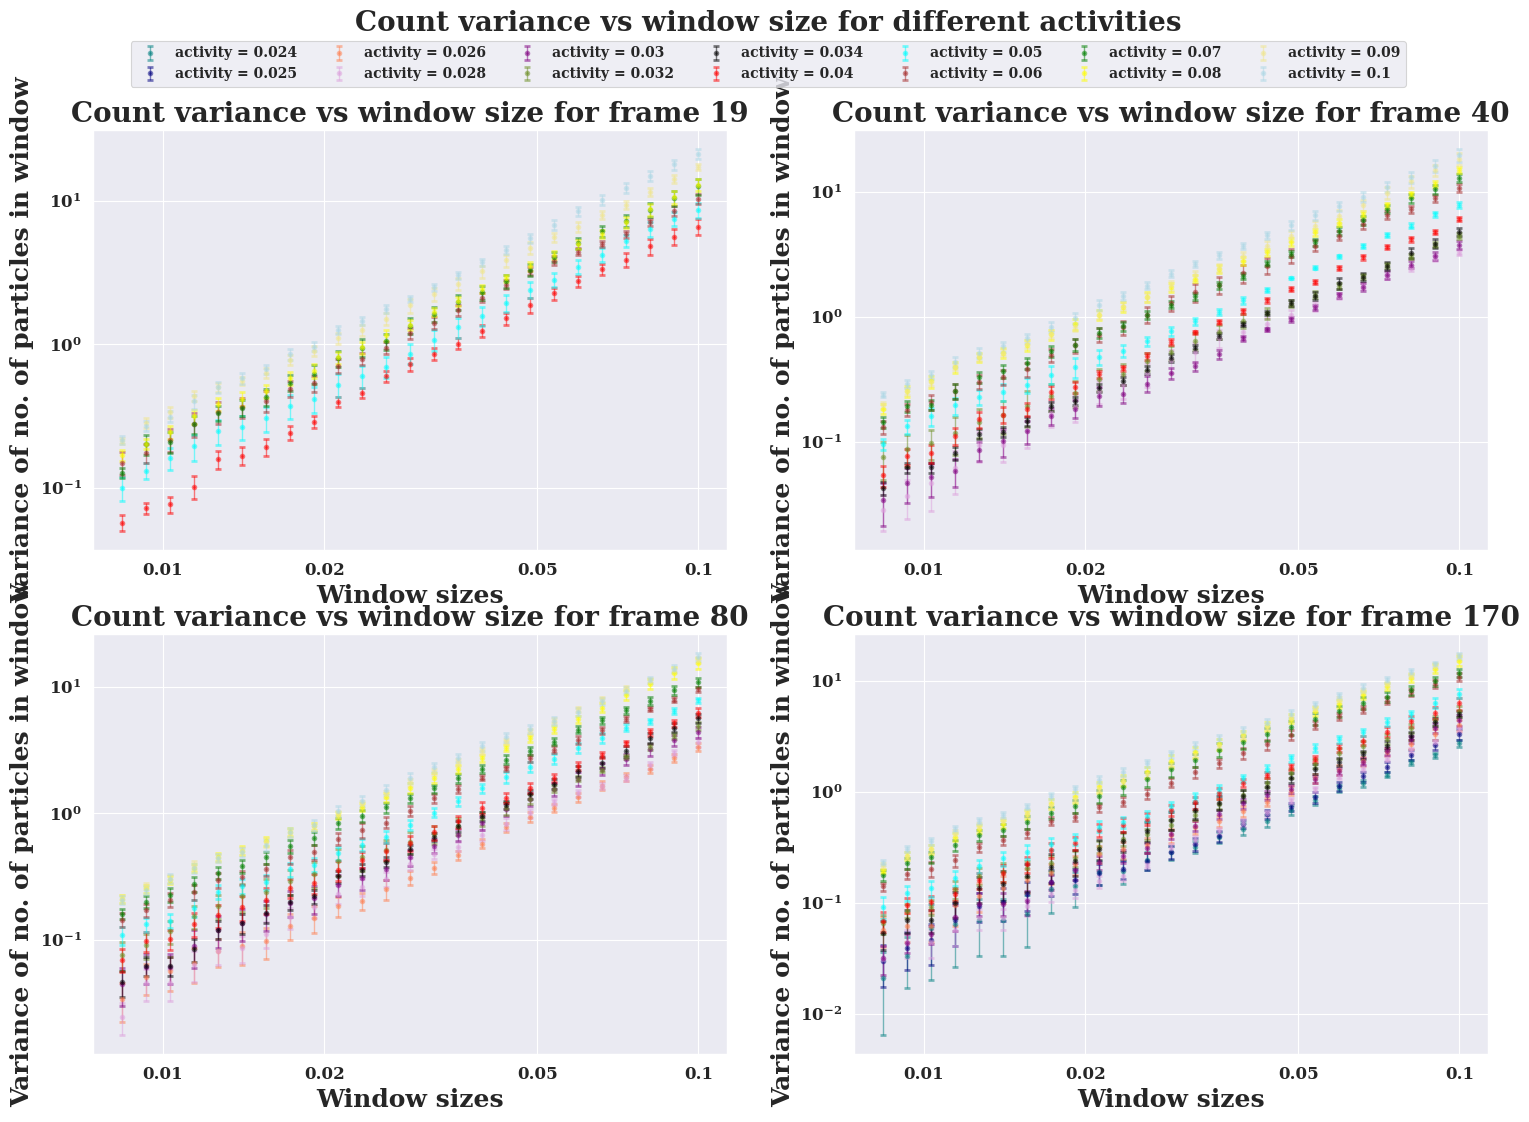

In [157]:
frames = [19, 40, 80, 170]
logplot = True
min_window_idx = 5


fig, ax = plt.subplots(nrows = 2, ncols = 2, figsize=(18, 12))
ax = ax.flatten()
for i, f in enumerate(frames):
    for j, act in enumerate(act_list):
        if i == 0:
            ax[i].errorbar(window_sizes[min_window_idx:], var_counts_av[f, min_window_idx:, j], var_counts_std[f, min_window_idx:, j], label='activity = {}'.format(act), fmt='.', \
                   capsize=2, capthick=1, elinewidth=1, markeredgewidth=2, alpha = 0.5, markersize=4)
        else:
            ax[i].errorbar(window_sizes[min_window_idx:], var_counts_av[f, min_window_idx:, j], var_counts_std[f, min_window_idx:, j], fmt='.', \
                    capsize=2, capthick=1, elinewidth=1, markeredgewidth=2, alpha = 0.5, markersize=4)

    ax[i].set_xlabel('Window sizes')
    ax[i].set_ylabel('Variance of no. of particles in window')
    ax[i].set_title('Count variance vs window size for frame {}'.format(f))
    if logplot:
        ax[i].set_yscale('log')
        ax[i].set_xscale('log')
        ax[i].set_xticks([2.56, 2 * 2.56, 5 * 2.56, 10 * 2.56], labels = np.round([2.56 / 256, 2 * 2.56 / 256, 5 * 2.56 / 256, 10 * 2.56 / 256],2))
  
    #ax[i].legend()
#add legend above the plot in 3 rows
fig.legend(loc='upper center', ncol=7, fontsize = 10, bbox_to_anchor=(0.5, 0.96))
fig.suptitle('Count variance vs window size for different activities', fontsize=20)

plt.show()

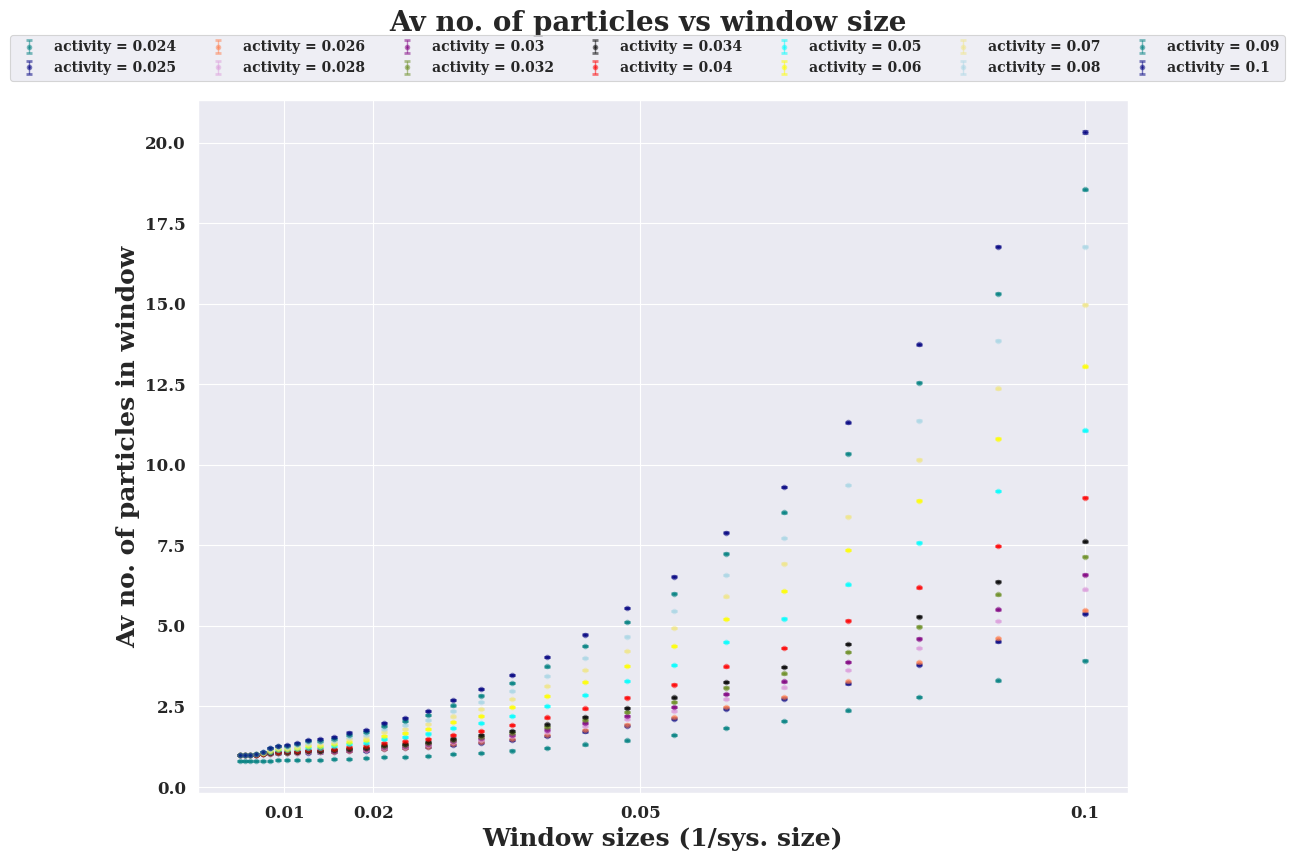

In [73]:
Nframes_non_nan_counts = np.sum(~np.isnan(av_counts_av), axis=0)[0]

fig, ax = plt.subplots(figsize=(12,9))

count_per_act_av = np.nanmean(av_counts_av, axis=0)
count_per_act_std = np.nanstd(av_counts_av, axis=0, ddof=1) / np.sqrt(Nframes_non_nan_counts[np.newaxis, :])

for j, act in enumerate(act_list):
    ax.errorbar(window_sizes, count_per_act_av[:,j], count_per_act_std[:,j], fmt='.',  label='activity = {}'.format(act), \
                        capsize=2, capthick=1, elinewidth=1, markeredgewidth=2, alpha = 0.5, markersize=4)
ax.set_xlabel('Window sizes (1/sys. size)')
ax.set_ylabel('Av no. of particles in window')
fig.suptitle('Av no. of particles vs window size')
ax.set_xticks([2.56, 2 * 2.56, 5 * 2.56, 10 * 2.56], labels = np.round([2.56 / 256, 2 * 2.56 / 256, 5 * 2.56 / 256, 10 * 2.56 / 256],2))
fig.legend(loc='upper center', ncol=7, fontsize = 10, bbox_to_anchor=(0.5, 0.95))

plt.show()
if 0:
    for i, f in enumerate(frames):
        for j, act in enumerate(act_list):
            if i == 0:
                ax[i].errorbar(window_sizes, av_counts_av[f, :, j], av_counts_std[f, :, j], label='activity = {}'.format(act), fmt='.', \
                    capsize=2, capthick=1, elinewidth=1, markeredgewidth=2, alpha = 0.5, markersize=4)
            else:
                ax[i].errorbar(window_sizes, av_counts_av[f, :, j], av_counts_std[f, :, j], fmt='.', \
                        capsize=2, capthick=1, elinewidth=1, markeredgewidth=2, alpha = 0.5, markersize=4)

        ax[i].set_xlabel('Window sizes (1/sys. size)')
        ax[i].set_ylabel('Av no. of particles in window')
        ax[i].set_title('Av count vs window size for frame {}'.format(f))
        ax[i].set_xticks([2.56, 2 * 2.56, 5 * 2.56, 10 * 2.56], labels = np.round([2.56 / 256, 2 * 2.56 / 256, 5 * 2.56 / 256, 10 * 2.56 / 256],2))
        #ax[i].legend()
    #add legend above the plot in 3 rows
    fig.legend(loc='upper center', ncol=7, fontsize = 10, bbox_to_anchor=(0.5, 0.96))
    fig.suptitle('Average count vs window size for different activities', fontsize=20)

    plt.show()

c:\Users\Simon Andersen\miniconda3\envs\tf\lib\site-packages\matplotlib\axes\_base.py:2503: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)


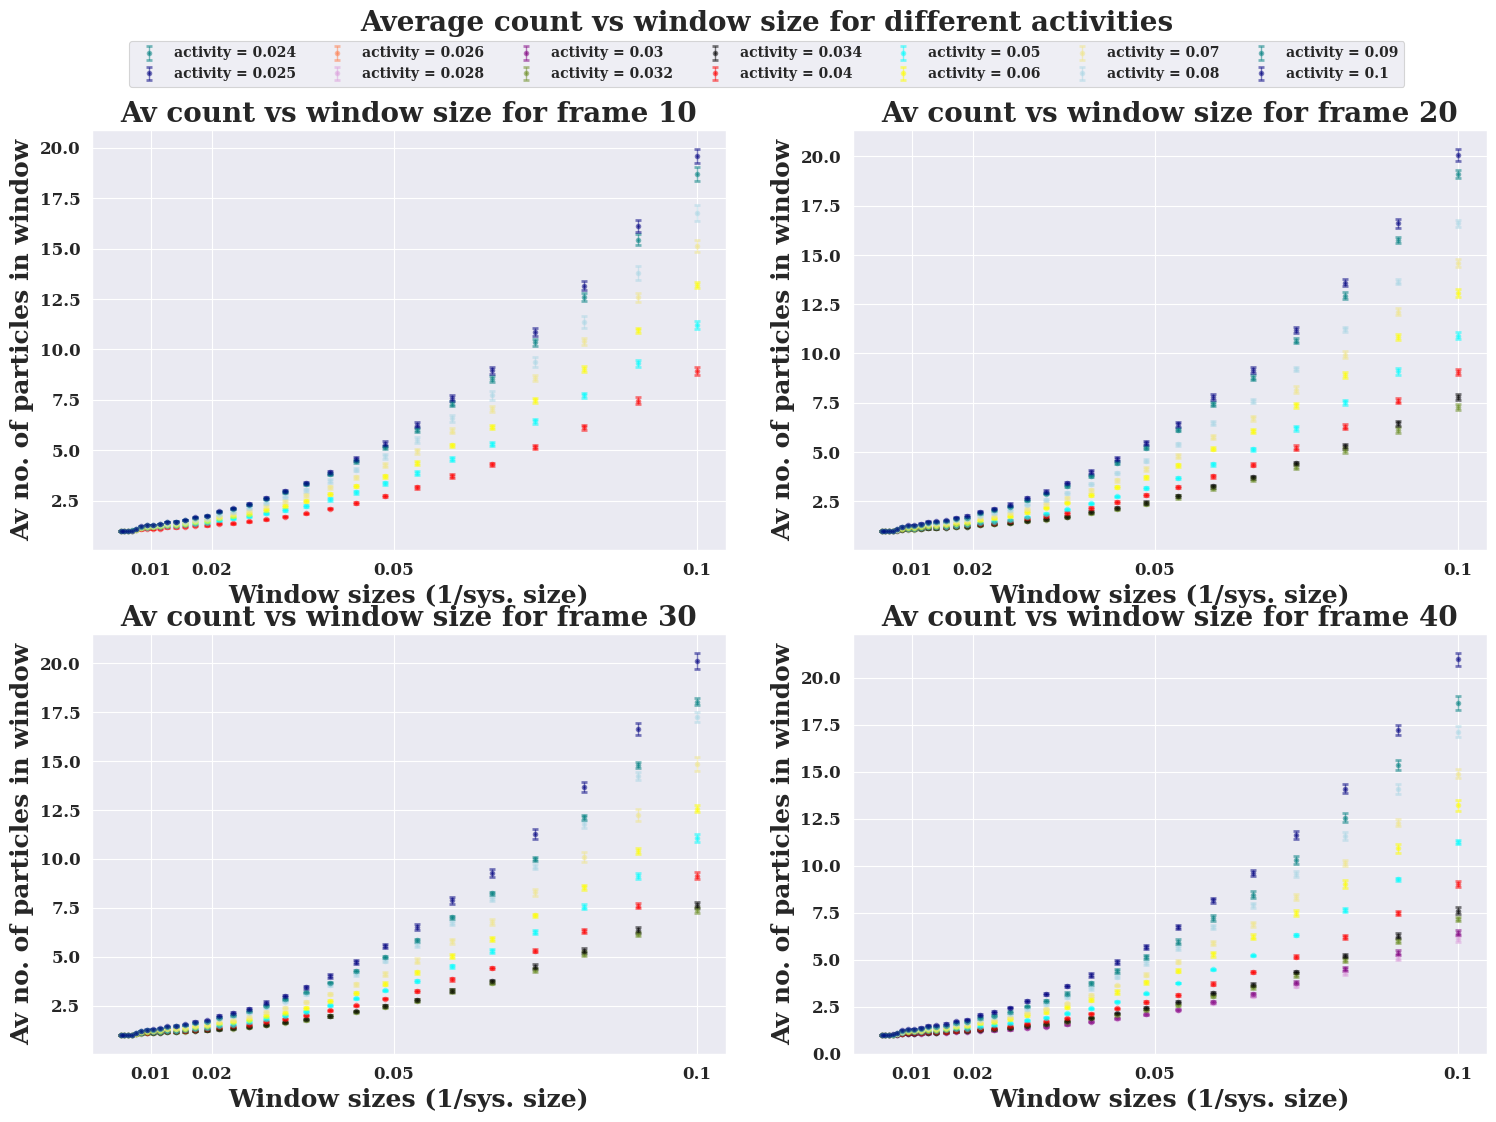

In [19]:
frames = [10,20,30,40]

fig, ax = plt.subplots(nrows = 2, ncols = 2, figsize=(18, 12))
ax = ax.flatten()
for i, f in enumerate(frames):
    for j, act in enumerate(act_list):
        if i == 0:
            ax[i].errorbar(window_sizes, av_counts_av[f, :, j], av_counts_std[f, :, j], label='activity = {}'.format(act), fmt='.', \
                   capsize=2, capthick=1, elinewidth=1, markeredgewidth=2, alpha = 0.5, markersize=4)
        else:
            ax[i].errorbar(window_sizes, av_counts_av[f, :, j], av_counts_std[f, :, j], fmt='.', \
                    capsize=2, capthick=1, elinewidth=1, markeredgewidth=2, alpha = 0.5, markersize=4)

    ax[i].set_xlabel('Window sizes (1/sys. size)')
    ax[i].set_ylabel('Av no. of particles in window')
    ax[i].set_title('Av count vs window size for frame {}'.format(f))
    ax[i].set_xticks([2.56, 2 * 2.56, 5 * 2.56, 10 * 2.56], labels = np.round([2.56 / 256, 2 * 2.56 / 256, 5 * 2.56 / 256, 10 * 2.56 / 256],2))
    #ax[i].legend()
#add legend above the plot in 3 rows
fig.legend(loc='upper center', ncol=7, fontsize = 10, bbox_to_anchor=(0.5, 0.96))
fig.suptitle('Average count vs window size for different activities', fontsize=20)

plt.show()

In [21]:
def calc_weighted_mean(x, dx, axis = -1):
    """
    returns: weighted mean, error on mean, Ndof, Chi2, p_val
    """
    assert(len(x) > 1)
    assert(len(x) == len(dx))
    
    var = 1 / np.sum(1 / dx ** 2, axis = axis)
    mean = np.sum(x / dx ** 2, axis = axis) * var

    return mean, np.sqrt(var)


In [52]:
y, dy = calc_weighted_mean(av_defects[:,0], av_defects[:,1])

In [46]:
x, dx = calc_weighted_mean(var_counts_av[:,6:,7:], var_counts_std[:,6:,7:], axis = 0)

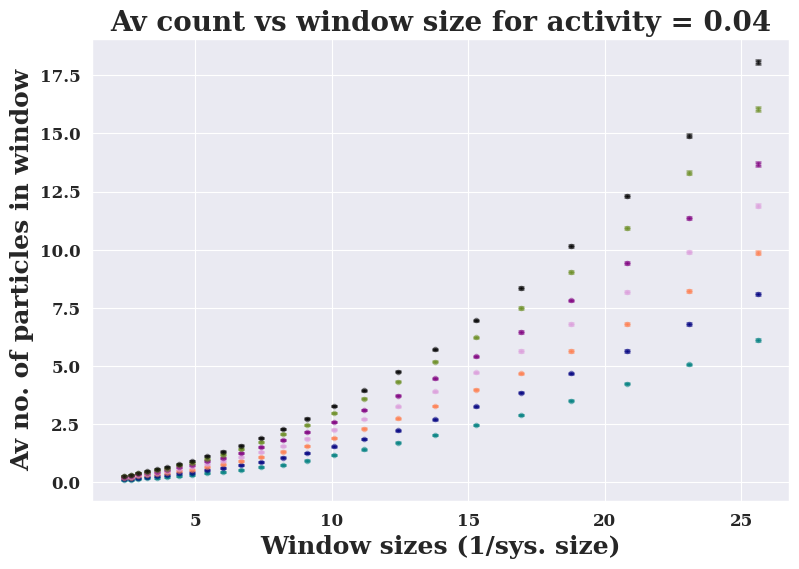

In [50]:
fig, ax = plt.subplots(figsize=(9,6))
for i, act in enumerate(act_list[7:]):
    ax.errorbar(window_sizes[6:], x[:,i], dx[:,i], fmt='.', label = f'Act = {act}',\
                        capsize=2, capthick=1, elinewidth=1, markeredgewidth=2, alpha = 0.5, markersize=4)

ax.set_xlabel('Window sizes (1/sys. size)')
ax.set_ylabel('Av no. of particles in window')
ax.set_title('Av count vs window size for activity = {}'.format(act_list[7]))
plt.show()